In [1]:
# import libraries to facilitate calculations and data prep
import os
import math
import pandas as pd
import numpy as np

In [2]:
# load the same pre-processed data

trainX_path = "./trainX.csv"
trainY_path = "./trainY.csv" 
testX_path = "./testX.csv" 
testY_path = "./testY.csv" 

df_trainX = pd.read_csv(trainX_path)
df_trainY = pd.read_csv(trainY_path)
df_testX = pd.read_csv(testX_path)
df_testY = pd.read_csv(testY_path)

In [3]:
trainX = df_trainX.values
trainY = df_trainY.values
testX = df_testX.values
testY = df_testY.values

# DNN model construction function

In [4]:
from keras import models
from keras import layers
from keras.layers import Activation
from keras.layers import BatchNormalization
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
import numpy as np
import time

from keras import backend as K

def makeModel(inputdim, funnel_prop=1.0, acti_func='swish', Dropout_prop = 0.1, addBN=False, labelSmoothingStrength=0.0):
  initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
  M_model = models.Sequential()

  #Input Layer#
  num_neurons = int(inputdim*funnel_prop)
  M_model.add(layers.Dense(num_neurons, input_dim=inputdim, activation=acti_func, kernel_initializer=initializer))
  if (addBN):
    M_model.add(BatchNormalization())
  #don't add dropout right after input layer#

  #Hidden layer 1#
  num_neurons = int(num_neurons*funnel_prop)
  M_model.add(layers.Dense(num_neurons,activation=acti_func, kernel_initializer=initializer))
  if (Dropout_prop>0.0000001):
    M_model.add(layers.Dropout(Dropout_prop))
  if (addBN):
    M_model.add(BatchNormalization())

  #Hidden layer 2#
  num_neurons = int(num_neurons*funnel_prop)
  M_model.add(layers.Dense(num_neurons, activation=acti_func, kernel_initializer=initializer))
  if (Dropout_prop>0.0000001):
    M_model.add(layers.Dropout(Dropout_prop))
  if (addBN):
    M_model.add(BatchNormalization())

  #Hidden layer 3#
  num_neurons = int(num_neurons*funnel_prop)
  M_model.add(layers.Dense(num_neurons, activation=acti_func, kernel_initializer=initializer))
  if (Dropout_prop>0.0000001):
    M_model.add(layers.Dropout(Dropout_prop))
  if (addBN):
    M_model.add(BatchNormalization())

  #output layer#
  M_model.add(layers.Dense(2, activation='softmax'))

  #Configure loss function & target label smoothing (regularization)#
  cce_loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=labelSmoothingStrength,
    axis=-1,
    reduction="auto",
    name="categorical_crossentropy",
)
  #Float in [0, 1]. When > 0, 
  #label values are smoothed, 
  #meaning the confidence on label values are relaxed. 
   #For example, if 0.1, use 0.1 / num_classes for non-target labels 
  # and 0.9 + 0.1 / num_classes for target labels.

  #Configure optimizer, using SGD only for this project#
  opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
  
  print(M_model.summary())

  M_model.compile(optimizer=opt, loss=cce_loss, metrics=['acc', 
#                                                          f1_m, precision_m, recall_m
                                                        ])
  
  return M_model

# Next we aim to find the best hyper parameters for this dataset. Due to large number of permutations and we limited ourselves to DNNs with 3 hidden layers and vary the following:
  ## Regularization-related params:
    1. Label Smoothing (has a regularization effect on the loss function as binary classes are now not absolute 1 or 0)
    2. Batch Normalization (may improve convergence and generalization of model)
    3. Dropout (randomly "turns off" proportion of neurons for the hidden layer during training. Has a ensemble learning effect as it trains a slighly different NN in each forward pass.)
  ## Architecture params:
    1. Funnel "Width" of NN (What proportion of dimension is reduced after each hidden layer) 
    2. Activation function
## In total we have trained 486 models for 10 epochs, each cross validated 3 folds over the train dataset. The average test accuracy for a model config was logged and saved into DNN_results.txt 

In [6]:
#Finding the best hyperparameters for this dataset#
#Params to iterate#
RUN_HYPARAM_SEARCH = False
result_dict = {}

labelSmoothingStrength_lst = [0.0, 0.25, 0.5]
Dropout_prop_lst = [0.0, 0.25, 0.5]
batchSize_lst = [16, 32, 64] #to decide if a small/large batch size is better#
funnel_prop_lst = [0.5, 0.75, 1.0]
applyBatchNorm = [True, False]
acti_func_lst = [ 'sigmoid', 'relu', 'swish']

num_perm = len(labelSmoothingStrength_lst)*len(Dropout_prop_lst)*len(batchSize_lst)*len(funnel_prop_lst)*len(applyBatchNorm)*len(acti_func_lst)
print("Number of perms for DNNs: {}".format(num_perm))

if (RUN_HYPARAM_SEARCH):
  perm_count = 0
  folds = 3
  skf = StratifiedKFold(n_splits=folds) #3 folds cross validation#
  skf.get_n_splits(trainX, trainY)
  result_dict = {}
  epnum = 10
  for lss in labelSmoothingStrength_lst:
    for fp in funnel_prop_lst:
      for bsz in batchSize_lst:
        for dp in Dropout_prop_lst:
          for bn in applyBatchNorm:
            for actif in acti_func_lst:
              now = time.time()
              perm_count+=1
              modelcfg = "lss:{},fp:{},bsz:{},dp:{},bn:{},acti:{}".format(lss,fp,bsz,dp,bn,actif)
              if modelcfg in result_dict:
                print("{}/{} ModelCFG:{}, Average Acc over {} folds cross validation: {:.2f}%".format(perm_count,num_perm, modelcfg,folds,result_dict[modelcfg]*100))
                continue
              sum_acc = 0.0
              model = makeModel(trainX.shape[1], funnel_prop=fp, acti_func=actif, Dropout_prop = dp, addBN=bn, labelSmoothingStrength=lss)
              saveinitWeights = model.get_weights() #for resetting later#
              for train_index, val_index in skf.split(trainX, trainY.argmax(1)):
                model.set_weights(saveinitWeights)
                history = model.fit(trainX[train_index], trainY[train_index], epochs=epnum, batch_size=bsz, validation_data=(trainX[val_index],trainY[val_index]), verbose=0, shuffle=True)
                sum_acc+= max(history.history['val_accuracy'])
              avg_acc = sum_acc / folds
              result_dict[modelcfg] = avg_acc
              later = time.time()
              print("{}/{} ModelCFG:{}, Average Acc over {} folds cross validation: {:.2f}%, Time Taken:{}s".format(perm_count,num_perm, modelcfg,folds,avg_acc*100,later-now))

else: #Skip search, read from saved results.txt#
  with open("./DNN_results.txt") as f:
      for line in f:
        (key, val) = line.split()
        result_dict[key[1:-2]] = float(val[:-1])
  s_result_dict = dict(sorted(result_dict.items(), key=lambda item: item[1],reverse=True))

Number of perms for DNNs: 486


FileNotFoundError: [Errno 2] No such file or directory: './DNN_results.txt'

# Due to imbalanced data (~88.3% of 1 class), that we found out after training 486 models. Most models were not be able to overcome the 88.3% test accuracy mark. (Overfitted on 1 class)

# Nevertheless, we foucsed on models that are able to exceed this 88.3% test accuracy, where only ~5% of 486 models met this accuracy mark.

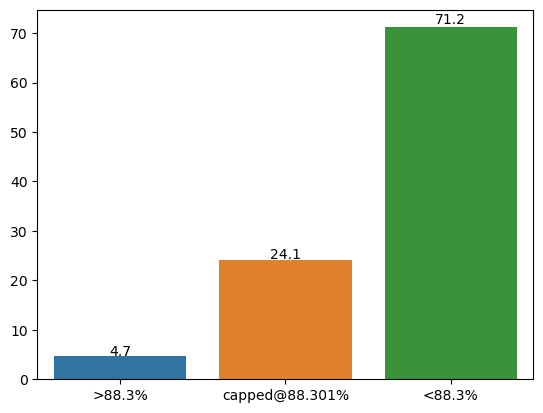

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

result_dict_count = {}
for item in s_result_dict.items():
  val = item[1]
  if (float(val) < 0.883):
    label = "<88.3%"
  elif (float(val) > 0.88302):
    label = ">88.3%"
  else:
    label = "capped@88.301%"
  if not label in result_dict_count:
    result_dict_count[label]=1
  else:
    result_dict_count[label]+=1
result_dict_count
for i in result_dict_count:
  result_dict_count[i] = round(result_dict_count[i]/486*100,2)

vals =  [float(i) for i in result_dict_count.values()]
keys = list(result_dict_count.keys())
ax = sns.barplot(x=keys,y=vals)
show_values(ax, "v", space=0)

#roughly 5% reached better results#

In [7]:
lss = {}
fp={}
bsz = {}
dp = {}
bn = {}
acti={}

def updateDict(dic, val):
  if not val[1] in dic:
    dic[val[1]] = 1
  else:
    dic[val[1]] += 1

for item in s_result_dict.items():
  if item[1]>.88302:
    #print(item)
    hyperparams = item[0].split(",")
    for p in hyperparams:
      val = p.split(":")
      if val[0]=='lss':
        updateDict(lss,val)
      if val[0]=='fp':
        updateDict(fp,val)
      if val[0]=='bsz':
        updateDict(bsz,val)
      if val[0]=='dp':
        updateDict(dp,val)
      if val[0]=='bn':
        updateDict(bn,val)
      if val[0]=='acti':
        updateDict(acti,val)

print("Label Smoothing:", lss)
print("Funnel proportion:", fp)
print("Batch Size:", bsz)
print("Dropout prop:", dp)
print("Batch Norm:", bn)
print("Activation Function:", acti)
print("By voting measure we should use: No label smoothing, Funnel Prop of 0.5, Batch Size of 16, dropout of 0.5, No batch norm & ReLu activation function")

Label Smoothing: {'0.0': 8, '0.5': 8, '0.25': 7}
Funnel proportion: {'0.75': 10, '0.5': 11, '1.0': 2}
Batch Size: {'32': 8, '16': 11, '64': 4}
Dropout prop: {'0.5': 12, '0.25': 8, '0.0': 3}
Batch Norm: {'False': 20, 'True': 3}
Activation Function: {'relu': 10, 'swish': 7, 'sigmoid': 6}
By voting measure we should use: No label smoothing, Funnel Prop of 0.5, Batch Size of 16, dropout of 0.5, No batch norm & ReLu activation function


In [7]:
# Best config = 
#   lss = 0
#   fp = 0.5
#   bsz = 16
#   dp = 0.5
#   bn = False
#   acti = relu

def scheduler(epoch, lr):
  if (epoch+1) % 10 == 0:
    return lr
  else:
    return lr * tf.math.exp(-0.0001)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
modelv1 = makeModel(trainX.shape[1], funnel_prop=0.5, acti_func='relu', Dropout_prop = 0.5, addBN=False, labelSmoothingStrength=0.0)
historyv1 = modelv1.fit(trainX, trainY, epochs=30, batch_size=16, validation_data=(testX,testY), verbose=2, callbacks=[callback], shuffle=True)
modelv1.save('5a_modelv1.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                312       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 21        
_________________________________________________________________
dropout_2 (Dropout)          (None, 3)                 0

In [8]:
#Added imbalanced class weights onto the loss function (see model.fit)#
from sklearn.utils import class_weight
yints = list(trainY.argmax(1))
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(yints), y= yints)
class_weights = dict(zip(np.unique(yints), class_weights))
print(class_weights)
modelv2 = makeModel(trainX.shape[1], funnel_prop=0.5, acti_func='relu', Dropout_prop = 0.5, addBN=False, labelSmoothingStrength=0.0)
historyv2 = modelv2.fit(trainX, trainY, epochs=30, batch_size=16, validation_data=(testX,testY), verbose=2, callbacks=[callback], shuffle=True, class_weight=class_weights)
modelv2.save('5b_modelv2.h5')

{0: 0.5662397845758838, 1: 4.27416686362562}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 25)                1300      
_________________________________________________________________
dense_6 (Dense)              (None, 12)                312       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 78        
_________________________________________________________________
dropout_4 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 21        
_________________________________________________________________
dropout_5

# training is unstable, I suspect is due to low number of trainable parameters

In [9]:
#Increased # of neurons, removed dropout & added batch norm to get a stable training going#
modelv3 = makeModel(trainX.shape[1], funnel_prop=1.0, acti_func='relu', Dropout_prop = 0.0, addBN=True, labelSmoothingStrength=0.0)
historyv3 = modelv3.fit(trainX, trainY, epochs=100, batch_size=16, validation_data=(testX,testY), verbose=2, shuffle=True, class_weight=class_weights)
modelv3.save('5c_modelv3.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 51)                2652      
_________________________________________________________________
batch_normalization (BatchNo (None, 51)                204       
_________________________________________________________________
dense_11 (Dense)             (None, 51)                2652      
_________________________________________________________________
batch_normalization_1 (Batch (None, 51)                204       
_________________________________________________________________
dense_12 (Dense)             (None, 51)                2652      
_________________________________________________________________
batch_normalization_2 (Batch (None, 51)                204       
_________________________________________________________________
dense_13 (Dense)             (None, 51)               

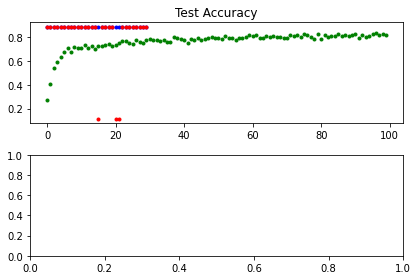

In [12]:
#Plot test results over epochs#
hist_results = [historyv1,historyv2,historyv3]
hist_names = ["No class weights", "With class weights", "With class weights-Stable"]
hist_colors = ["b", "r", "g"]
test_metric = ["val_acc"]
test_metric_title = ["Test Accuracy"]
fig2, axes = plt.subplots(2)
for idx, h in enumerate(hist_results):
  for idx2, metric in enumerate(test_metric):
    k = h.history[metric]
    axes[idx2].scatter(range(len(k)),k, c=hist_colors[idx], marker='.', label=hist_names[idx])
    axes[idx2].set_title(test_metric_title[idx2])
fig2.tight_layout()
plt.show()

# Blue: No class weighing. Using hyperparam searched DNN, 88.3% accuracy, overfitted wrongly --> to plot confusion matrix
# Red: Unstable DNN training with class weighing for imbalanced class
# Green: Stabalized DNN training with class weighing for imbalanced class
# Best acc with DNN ~83.32%

In [13]:
max(historyv3.history['val_acc'])

0.8332227468490601

Text(0.5, 1.0, 'Test Accuracy')

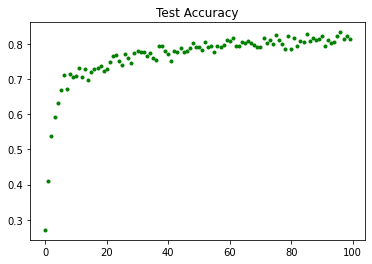

In [14]:
data = historyv3.history['val_acc']
plt.scatter(range(len(data)),data, c=hist_colors[idx], marker='.', label=hist_names[idx])
plt.title(test_metric_title[idx2])


#### to compute f1 and display confusion matrix

              precision    recall  f1-score   support

           n       0.99      0.80      0.88      7984
           y       0.38      0.96      0.55      1058

    accuracy                           0.81      9042
   macro avg       0.69      0.88      0.72      9042
weighted avg       0.92      0.81      0.84      9042



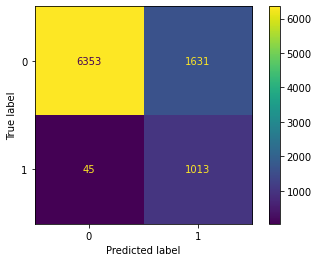

In [15]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score

def genCMfromDNN(evalY,y_prediction):
  #y_predictions are post-softmax form, i.e. [0.7,0.3]#
  arr = []
  for i in y_prediction:
    binary_pred = np.argmax(i)
    if binary_pred:
      lst = [0,1]
    else:
      lst = [1,0]
    arr.append(lst)
  y_pred = np.array(arr)

  #reverse to_categorical#
  testY_class = list(evalY.argmax(1))
  y_pred_class = list(y_pred.argmax(1))

  #generate CM#
  cm = confusion_matrix(testY_class,y_pred_class)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  print(classification_report(testY_class,y_pred_class,target_names=['n','y']))


modelvTEST = tf.keras.models.load_model("5c_modelv3.h5")
# y_hat_train = modelvTEST.predict(trainX)
y_hat_test = modelvTEST.predict(testX)

# genCMfromDNN(trainY,y_hat_train)
genCMfromDNN(testY,y_hat_test)